# Análise comparativa de modelos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

colors = ["#9467bd", "#057476", "#FF7A00"]
sns.set_theme(style="ticks")
sns.set_palette(sns.color_palette(colors))

## 1. Obtenção de dados

In [2]:
# Carregar o arquivo dos dados
df = pd.read_csv("../data/raw/Sleep_health_and_lifestyle_dataset.csv")
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [3]:
# Carregar o dicionário
dicionario = pd.read_csv("../data/external/dictionary.csv")
dicionario

,variavel,descrição,tipo,subtipo
0,Gender,O gênero da pessoa (Masculino/Feminino),qualitativa,nominal
1,Age,A idade da pessoa em anos,quantitativa,discreta
2,Occupation,A ocupação ou profissão da pessoa,qualitativa,nominal
3,Sleep Duration,O número de horas que a pessoa dorme por dia,quantitativa,contínua
4,Quality of Sleep,Uma classificação subjetiva da qualidade do so...,quantitativa,discreta
5,Physical Activity Level,O número de minutos que a pessoa pratica ativi...,quantitativa,discreta
6,Stress Level,Uma classificação subjetiva do nível de estres...,quantitativa,discreta
7,BMI Category,"A categoria de IMC da pessoa (por exemplo, Aba...",qualitativa,ordinal
8,Blood Pressure,"A medição da pressão arterial da pessoa, indic...",qualitativa,ordinal
9,Heart Rate,A frequência cardíaca em repouso da pessoa em ...,quantitativa,discreta


## 2. Preparação de dados

### -  Limpeza de dados

In [4]:
# Redução - excluir coluna que não traz nenhum tipo informação
# Excluir a coluna 'Person ID'
df = df.drop(['Person ID'], axis = 1)

In [5]:
# Verificar valores missing ou NAM (valores faltantes)
df.isnull().sum()

Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Blood Pressure             0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
dtype: int64

Tratamento para a variável IMC

In [6]:
df['BMI Category']

0      Overweight
1          Normal
2          Normal
3           Obese
4           Obese
          ...    
369    Overweight
370    Overweight
371    Overweight
372    Overweight
373    Overweight
Name: BMI Category, Length: 374, dtype: object

Não há dados faltantes neste dataset.

Para a variável categórica BMI category, deve-se considerar que: 

- 'Overweight' and 'Obese' têm o mesmo significado, portanto, todas as entradas na tabela de dormir relativas a Overweight são alteradas para Obese.
- 'Normal' and 'Normal Weight' também têm o mesmo significado, portanto, todas as ocorrências de Normal Weight são alteradas para Normal

In [7]:
df['BMI Category'] = df['BMI Category'].mask(df['BMI Category'] == 'Overweight', 'Obese')
df['BMI Category'] = df['BMI Category'].mask(df['BMI Category'] == 'Normal Weight', 'Normal')
df["BMI Category"].unique()

array(['Obese', 'Normal'], dtype=object)

Tratamento para a variável Blood Pressure

In [8]:
df['Blood Pressure']

0      126/83
1      125/80
2      125/80
3      140/90
4      140/90
        ...  
369    140/95
370    140/95
371    140/95
372    140/95
373    140/95
Name: Blood Pressure, Length: 374, dtype: object

De acordo com a [Departamento de Hipertensão Arterial](http://departamentos.cardiol.br/dha/consenso3/capitulo1.asp), para a varável categórica Pressão arterial (Blood Pressure) existe a seguinte classificação para adultos maiores que 18 anos: 

<div align="center">

<img width="400" title="Classificação da pressão arterial" src="../docs/assets/images/blood_pressure.png"/>

</div>

In [9]:
# Dicionário de mapeamento dos valores de pressão arterial para suas categorias
blood_pressure_mapping = {
    '126/83': 'Normal',
    '125/80': 'Normal',
    '120/80': 'Normal',
    '117/76': 'Normal',
    '118/76': 'Normal',
    '128/85': 'Normal',
    '128/84': 'Normal',
    '115/75': 'Normal',
    '129/84': 'Normal',
    '115/78': 'Normal',
    '119/77': 'Normal',
    '121/79': 'Normal',
    '125/82': 'Normal',
    '122/80': 'Normal',
    '118/75': 'Normal',
    '132/87': 'Normal Limitrofe',
    '130/86': 'Normal Limitrofe',
    '131/86': 'Normal Limitrofe',
    '135/88': 'Normal Limitrofe',
    '130/85': 'Normal Limitrofe',
    '135/90': 'Normal Limitrofe',
    '139/91': 'Normal Limitrofe',
    '140/90': 'Hipertensão Estagio 1',
    '142/92': 'Hipertensão Estagio 1',
    '140/95': 'Hipertensão Estagio 1'
}

# Aplicando o mapeamento ao dataframe
df['Blood Pressure'] = df['Blood Pressure'].replace(blood_pressure_mapping)

# Verificando os valores únicos após a substituição
df['Blood Pressure'].unique()

array(['Normal', 'Hipertensão Estagio 1', 'Normal Limitrofe'],
      dtype=object)

In [10]:
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Obese,Normal,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,Normal,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,Normal,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,Hipertensão Estagio 1,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,Hipertensão Estagio 1,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Obese,Hipertensão Estagio 1,68,7000,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Obese,Hipertensão Estagio 1,68,7000,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Obese,Hipertensão Estagio 1,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Obese,Hipertensão Estagio 1,68,7000,Sleep Apnea


In [11]:
# Separar as variáveis

variavel_alvo = 'Sleep Disorder'

colunas_nominais = (
    dicionario
    .query("subtipo == 'nominal' and variavel != @variavel_alvo")
    .variavel
    .to_list()
)

coluna_ordinal_imc = (
    dicionario
    .query("variavel in ['BMI Category']")
    .variavel
    .to_list()
)

coluna_ordinal_bp = (
    dicionario
    .query("variavel in ['Blood Pressure']")
    .variavel
    .to_list()
)

coluna_continua = (
    dicionario
    .query("subtipo == 'contínua'")
    .variavel
    .to_list()
)

colunas_discretas = (
    dicionario
    .query("subtipo == 'discreta'")
    .variavel
    .to_list()
)

colunas_quantitativas = (
    dicionario
    .query("tipo == 'quantitativa'")
    .variavel
    .to_list()
)



X = df.drop(columns=[variavel_alvo], axis=1)
y = df[variavel_alvo]

colunas_nominais, coluna_ordinal_imc, coluna_ordinal_bp, coluna_continua, colunas_discretas

(['Gender', 'Occupation'],
 ['BMI Category'],
 ['Blood Pressure'],
 ['Sleep Duration'],
 ['Age',
  'Quality of Sleep',
  'Physical Activity Level',
  'Stress Level',
  'Heart Rate',
  'Daily Steps'])

In [12]:
# Variáveis independente
X.head()


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps
0,Male,27,Software Engineer,6.1,6,42,6,Obese,Normal,77,4200
1,Male,28,Doctor,6.2,6,60,8,Normal,Normal,75,10000
2,Male,28,Doctor,6.2,6,60,8,Normal,Normal,75,10000
3,Male,28,Sales Representative,5.9,4,30,8,Obese,Hipertensão Estagio 1,85,3000
4,Male,28,Sales Representative,5.9,4,30,8,Obese,Hipertensão Estagio 1,85,3000


In [13]:
X.shape

(374, 11)

In [14]:
# Variável dependente
y

0             None
1             None
2             None
3      Sleep Apnea
4      Sleep Apnea
          ...     
369    Sleep Apnea
370    Sleep Apnea
371    Sleep Apnea
372    Sleep Apnea
373    Sleep Apnea
Name: Sleep Disorder, Length: 374, dtype: object

In [15]:
z_scores = stats.zscore(df.select_dtypes(include=[float, int]))
abs_z_scores = abs(z_scores)
filtro = (abs_z_scores < 3).all(axis=1)

novo_df = df[filtro]

X = novo_df

y = df[filtro][variavel_alvo]

In [16]:
X.shape

(365, 12)

In [17]:
y.shape

(365,)

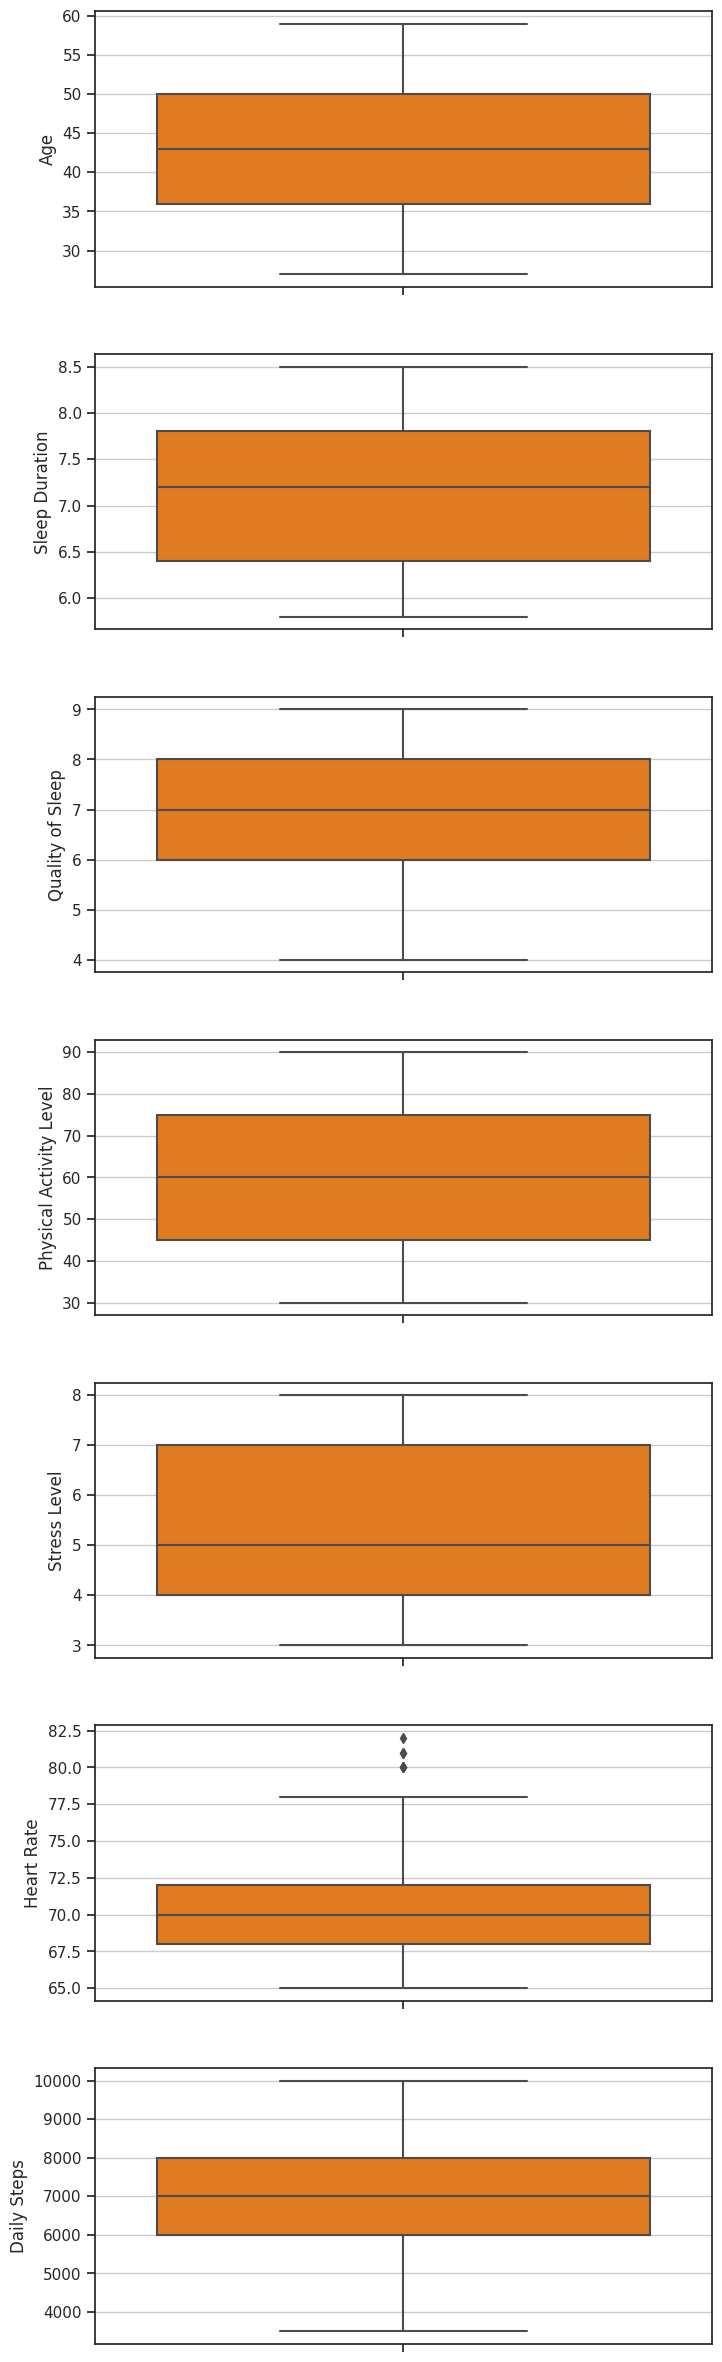

In [18]:
fig, axes = plt.subplots(7, 1, figsize=(8, 25))
plt.tight_layout(pad=4, w_pad=2, h_pad=2)

for i, variavel in enumerate(colunas_quantitativas):
    ax = sns.boxplot(
        y=X[variavel], 
        ax=axes[i],
        color=colors[2]
    ) 
    ax.grid(axis='y', linestyle='-')

plt.show()

### - Transformação de dados

In [19]:
# tratamento de dados discrepantes
nominal_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ('encoding', OneHotEncoder(sparse_output=False, drop='first')), # codificação de variáveis
    ('normalization', StandardScaler()) # normalização de dados
])

ordinal_imc_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ('encoding', OrdinalEncoder(categories=[['Normal', 'Obese']])), # codificação de variáveis
    ('normalization', StandardScaler()) # normalização de dados
])

ordinal_bp_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='most_frequent')), # tratamento de dados faltantes
    ('encoding', OrdinalEncoder(categories=[['Normal', 'Normal Limitrofe', 'Hipertensão Estagio 1']])), # codificação de variáveis
    ('normalization', StandardScaler()) # normalização de dados
])

continua_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='mean')), # tratamento de dados faltantes
    ('normalization', StandardScaler()) # normalização de dados
])

discreta_preprocessor = Pipeline([
    ('missing', SimpleImputer(strategy='median')), # tratamento de dados faltantes
    ('normalization', StandardScaler()) # normalização de dados
])

preprocessor = ColumnTransformer([
    ('nominal', nominal_preprocessor, colunas_nominais),
    ('ordinal_imc', ordinal_imc_preprocessor, coluna_ordinal_imc),
    ('ordinal_bp', ordinal_bp_preprocessor, coluna_ordinal_bp),
    ('continua', continua_preprocessor, coluna_continua),
    ('discreta', discreta_preprocessor, colunas_discretas)
])

model = LogisticRegression()

In [20]:
preprocessor.fit_transform(X)

array([[ 1.00825323, -0.47416475, -0.45673764, ...,  0.35003901,
         2.05661076, -1.75687037],
       [ 1.00825323,  2.1089716 , -0.45673764, ...,  1.48069601,
         1.48445914,  2.0133218 ],
       [ 1.00825323,  2.1089716 , -0.45673764, ...,  1.48069601,
         1.48445914,  2.0133218 ],
       ...,
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ],
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ],
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ]])

In [21]:
X_transform = preprocessor.transform(X)
X_transform

array([[ 1.00825323, -0.47416475, -0.45673764, ...,  0.35003901,
         2.05661076, -1.75687037],
       [ 1.00825323,  2.1089716 , -0.45673764, ...,  1.48069601,
         1.48445914,  2.0133218 ],
       [ 1.00825323,  2.1089716 , -0.45673764, ...,  1.48069601,
         1.48445914,  2.0133218 ],
       ...,
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ],
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ],
       [-0.99181432, -0.47416475, -0.45673764, ..., -1.34594648,
        -0.51807154,  0.0632224 ]])

## 3. Seleção de modelos

### 3.1 Resultados gerais

### 3.2 Persistência do modelo